In [23]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
#Importing libraries
%matplotlib inline
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame

from __future__ import division

import numpy as np
import lal
import lalsimulation

import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform

In [26]:
import pycbc.types
from pycbc.types import TimeSeries
time = dataset[:, 0]
strain = dataset[:, 1]
dataset = np.load("/content/drive/MyDrive/PRA3024_Big_Data_Analysis/Gravitational_Waves/noise_ts_4096Hz.npy")
dt = time[1] - time[0]
strain = TimeSeries(strain, delta_t=dt)
data = pycbc.types.TimeSeries(strain, delta_t = dt)


In [27]:
#Matched filtering
data = highpass(data, 15)
data = data.crop(4,4)
data_freq = data.to_frequencyseries()

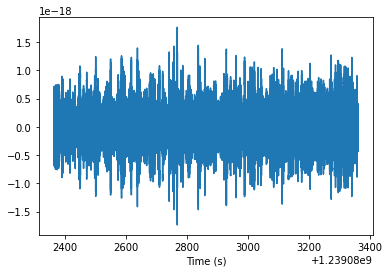

In [28]:
#Visualisation of strain
pylab.plot(time, strain) 
pylab.xlabel('Time (s)') 
pylab.show()

Text(0, 0.5, 'Strain in 1/$\\sqrt{Hz}$')

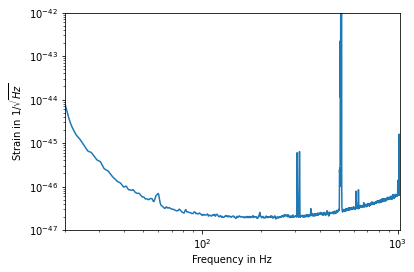

In [29]:
import pycbc.psd
from pycbc.psd import interpolate, inverse_spectrum_truncation
psds = {}
delta_t = data.delta_t
seg_len = int(2 / delta_t)
seg_stride = int(seg_len / 2)
psds = pycbc.psd.welch(data,  #power spectral density
                  seg_len=seg_len,
                  seg_stride=seg_stride)
stilde = strain.to_frequencyseries()
psds= interpolate(psds, stilde.delta_f)
#Including inverse spectrum truncation for additional noise removal
psds= inverse_spectrum_truncation(psds, int(2 * data.sample_rate),
                                low_frequency_cutoff=15.0,
                                trunc_method='hann')
pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)
pylab.xlabel("Frequency in Hz")
pylab.ylabel("Strain in 1/$\sqrt{Hz}$")


In [30]:
print(type(psds))

<class 'pycbc.types.frequencyseries.FrequencySeries'>


In [31]:
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.filter import resample_to_delta_t
import numpy
from pycbc.types import TimeSeries, FrequencySeries

# delta_f = 1.0 / (len(data) * delta_t)
# freqs = np.linspace(0, delta_f * (len(data)-1), len(data)//2 + 1)
# psd_freqseries = FrequencySeries(data[:len(freqs)], delta_f=delta_f)
# psd_freqseries.data *= 2 # scale to one-sided power spectral density
# psd_freqseries.data[0] /= 2 # remove double-counted DC component

#Generating templates for masses between 5 and 10 solar masses
mass1 = numpy.arange(5, 10,0.10)
mass2 = mass1

#2. Variables to store for finding the matched filter with highest SNR
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {} 
Snr_list = []

#3. Generating the waveform. 

for i in range(len(mass1)): 
    m = mass1[i] 
    hp, hc = get_td_waveform(approximant="TaylorT2",  #hp is plus, hc is cross ; using TaylorT2 approximant
                     mass1=m,
                     mass2=m,
                     delta_t=strain.delta_t,  #Setting time steps equal to that of the strain
                     f_lower=15.0)

    # Resizing hp to same length as strain
    hp.resize(len(strain))
    template = hp.cyclic_time_shift(hp.start_time) # template = K(t)
    
    #Calculating signal-to-noise ratio
    snr = matched_filter(template, strain,
                     psd=psds, low_frequency_cutoff=15.0)
    
    #Cropping SNR
    snr_H1 = snr.crop(4 + 4, 4)

    #Taking the max of the absolute value, to get the real part of the SNR
    Snr_list.append(max(abs(snr_H1)))





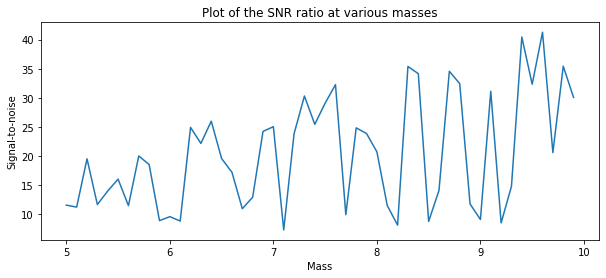

In [32]:
#Plotting SNR against mass
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, Snr_list)
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Mass')
pylab.title("Plot of the SNR ratio at various masses")
pylab.show()
#As can be seen, the max SNR is clearly higher than 8. However, the SNR tends to oscillate to high values over the entire mass range
#It may thus not be an actual signal

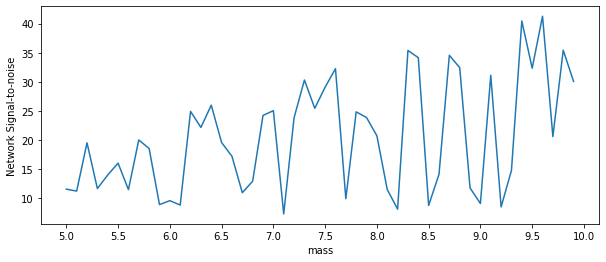

We found the best Mass1=Mass2 was 9.60 solar masses (detector frame)


In [33]:
#Finding best mass value
ii = numpy.where(Snr_list == max(Snr_list))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, Snr_list)
plt.xticks(np.arange(5, 10.5, 0.5))
pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

In [34]:
#Whitening the data
whitened = (stilde / psds**0.5).to_timeseries()
whitened = whitened.highpass_fir(50., 512).lowpass_fir(300, 512)

#Finding the time around the max SNR
max_snr_time = np.argmax(Snr_list)
dt = 0.3
start_time = max_snr_time - dt
end_time = max_snr_time + dt

#Selecting time around max SNR
whitened = whitened.time_slice(start_time, end_time)

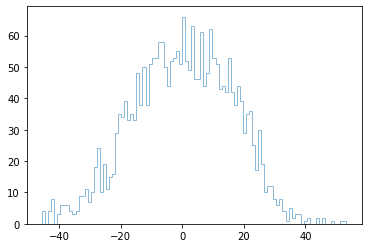

The mean is 0.0826559633135451
The standard deviation is 16.062242161734098


In [35]:
plt.hist(whitened, bins=100, histtype='step', alpha=0.5)
plt.show()
#We can see indeed a shape that represents a gaussian distribution, centered around 0
print("The mean is {}".format(np.mean(whitened))) #The mean is very close to 0, as expected
print("The standard deviation is {}".format(np.std(whitened)))

#This would indicate that even though there is a high SNR ratio, the data is simply noise

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


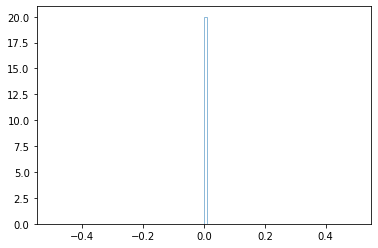

In [39]:
#Investigating the assumption that the noise is stationary
from pycbc.filter import sigmasq
from scipy import signal

#Generating an arbitrary waveform
mass = np.arange(1, 10, 0.5)
m = np.random.choice(mass)
hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=m,
                         mass2=m,
                         delta_f=1/200,
                         distance=500,
                         f_lower=20,
                         f_final=2048)

#Dividing the data into segments
n = 20 # Number of segments
segments = np.array_split(data, n)

#Creating psd for each segment
psds = []
for seg in segments:
    freqs, psd = signal.welch(seg, fs=1/hp.delta_t)
    psds.append(psd)

#Turning the psd's into frequency series
psd_fseries = []
for psd in psds:
    psd_fseries.append(pycbc.types.FrequencySeries(psd, delta_f=hp.delta_f))

#Finding the SNR's
SNR_list = []
for psd in psd_fseries:
    hp.resize(len(psd))
    SNR = (sigmasq(hp, psd))**0.5
    SNR_list.append(SNR)


print(SNR_list)
#Plotting a histogram
plt.hist(SNR_list, bins=100, histtype='step', alpha=0.5)
plt.show()

#For some reason, my code is returning only 0 values for the SNR. I don't understand why.

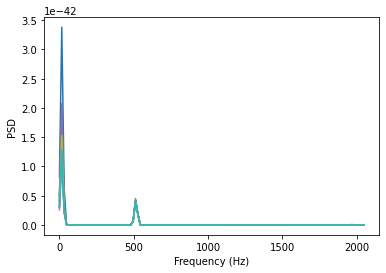

In [37]:
fig, ax = plt.subplots()
for psd in psds:
    ax.plot(freqs, psd)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')
plt.show()

#Most of the PSD's seem to be very close to zero, which might explain why the SNR is also all zeroes.